# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [ ]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv
!apt-get install poppler-utils -y
!apt-get install tesseract-ocr -y


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.4/523.4 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os

# keys for the services we will use

# os.environ["OPENAI_API_KEY"] = "sk-..."
os.environ["GROQ_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [ ]:
from unstructured.partition.pdf import partition_pdf

file_path = "/content/States.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path="extracted_data_pdfstates",   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    extract_images_in_pdf=True,          # deprecated
)



In [38]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [40]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.
print(len(chunks))
chunks[1].metadata.orig_elements

2


In [41]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[1].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '69e53167-d0fb-4ab2-b101-7b3730b77d37',
 'text': '',
 'metadata': {'coordinates': {'points': ((204.16666666666666,
     392.0522361111109),
    (204.16666666666666, 760.8021944444444),
    (543.7500222222221, 760.8021944444444),
    (543.7500222222221, 392.0522361111109)),
   'system': 'PixelSpace',
   'layout_width': 1656,
   'layout_height': 2339},
  'last_modified': '2025-03-07T13:31:25',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 2,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFxAVQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT

### Separate extracted elements into tables, text, and images

In [42]:
# separate tables from texts
tables = []
texts = []
images = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)
    if "Image" in str(type(chunk)):
        images.append(chunk)
    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [43]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

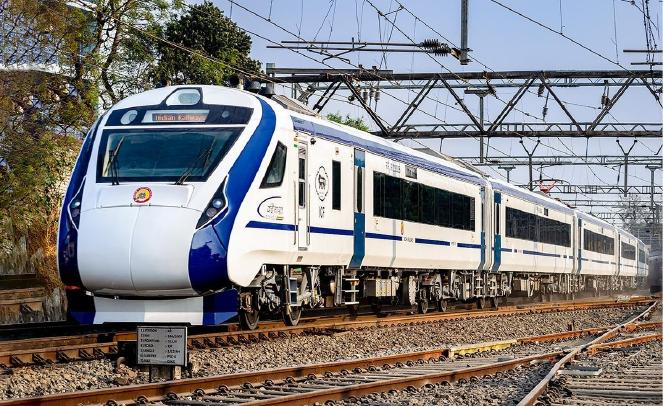

In [44]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[4])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [45]:
%pip install -Uq langchain-groq

In [46]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [47]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing images, tables and text.
Give a concise summary of the image, table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Image, Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.3, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [48]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})



In [49]:
text_summaries

["Tamil Nadu preserves India's oldest continuous classical civilization, with a rich cultural heritage in literature, dance, music, and architecture.",
 "West Bengal is a strategic state connecting mainland India to the northeast through the Siliguri Corridor, crucial for India's territorial integrity. It has a rich cultural heritage, influenced by British colonial legacy, and is home to the Durga Puja festival, a blend of traditional and contemporary art."]

### Image summaries

We will use llama-3.2-11b-vision-preview/
gpt-4o-mini to produce the image summaries.

In [31]:
%pip install -Uq langchain_openai

In [50]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a document containing various facts related to Indian states"""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatGroq(model="llama-3.2-11b-vision-preview") | StrOutputParser()


image_summaries = chain.batch(images)

In [51]:
image_summaries

['The image is a logo for the Government of Tamilnadu, featuring a prominent green circle with a yellow temple at its center. The temple is adorned with intricate carvings and has a large, ornate entrance gate.\n\nHere are the key elements of the logo:\n\n* **Green Circle:**\n\t+ The circle is the outermost element of the logo.\n\t+ It has a solid green color with a subtle gradient effect.\n\t+ The circle is slightly distorted, giving it a sense of depth and dimensionality.\n* **Yellow Temple:**\n\t+ The yellow temple is located at the center of the green circle.\n\t+ It is depicted in a stylized manner, with clean lines and simple shapes.\n\t+ The temple has a tall, rectangular shape with a flat roof.\n\t+ It features a large, ornate entrance gate with intricate carvings.\n\t+ The temple is surrounded by a series of concentric circles, adding to its sense of depth and dimensionality.\n* **Green Text:**\n\t+ The text "GOVERNMENT OF TAMILNADU" is written in bold, green letters along the

In [97]:
print(image_summaries[0])

The image is a logo for the Government of Tamilnadu, featuring a prominent green circle with a yellow temple at its center. The temple is adorned with intricate carvings and has a large, ornate entrance gate.

Here are the key elements of the logo:

* **Green Circle:**
	+ The circle is the outermost element of the logo.
	+ It has a solid green color with a subtle gradient effect.
	+ The circle is slightly distorted, giving it a sense of depth and dimensionality.
* **Yellow Temple:**
	+ The yellow temple is located at the center of the green circle.
	+ It is depicted in a stylized manner, with clean lines and simple shapes.
	+ The temple has a tall, rectangular shape with a flat roof.
	+ It features a large, ornate entrance gate with intricate carvings.
	+ The temple is surrounded by a series of concentric circles, adding to its sense of depth and dimensionality.
* **Green Text:**
	+ The text "GOVERNMENT OF TAMILNADU" is written in bold, green letters along the top edge of the green cir

## Load data and summaries to vectorstore

### Create the vectorstore

In [54]:
!pip install langchain_huggingface

In [55]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_huggingface import HuggingFaceEmbeddings

embeddings=HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        model_kwargs={"device": "cuda"})
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-55-685c6ddcd76f>:12: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)


### Load the summaries and link the to the original data

In [56]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
# Check if tables and table_summaries are not empty before processing
if tables and table_summaries:  # This condition ensures that both lists are not empty
    table_ids = [str(uuid.uuid4()) for _ in tables]
    summary_tables = [
        Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
    ]
    retriever.vectorstore.add_documents(summary_tables)
    retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [63]:
# Retrieve
docs = retriever.invoke(
    "Tell me about West Bengal?"
)

In [64]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

West Bengal: Where East Meets Northeast

West Bengal occupies a strategic position connecting mainland India to the northeastern states through the narrow Siliguri Corridor (sometimes called the "Chicken's Neck"). This geographical reality makes it a crucial link in India's territorial integrity.

The state's capital, Kolkata (formerly Calcutta), served as the capital of British India until 1911, creating a legacy of colonial architecture, educational institutions, and literary traditions that influenced all of eastern India. West Bengal's Durga Puja festival has evolved

into a artistic and cultural event that showcases contemporary creative expressions within traditional frameworks.

--------------------------------------------------------------------------------
/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAH+AnoD

## RAG pipeline

In [65]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    # Instead of a list of dictionaries, directly pass the prompt_template string
    prompt_content = prompt_template

    # Create a HumanMessage with the string content
    messages = [
        HumanMessage(content=prompt_content)
    ]

    # Handle image URLs separately and include them within the prompt
    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            # Include the image url within the prompt
            prompt_content += f"\nImage URL: data:image/jpeg;base64,{image}"

    # Create a ChatPromptTemplate with the modified content
    return ChatPromptTemplate.from_messages(messages)


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatGroq(model = "qwen-2.5-32b")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatGroq(model = "llama-3.2-11b-vision-preview")
        | StrOutputParser()
    )
)

In [93]:
response = chain.invoke(
    "Tell me about the state famous for temples"
)

print(response)

Based on the provided context, Tamil Nadu is the state famous for its temples. The context mentions that Tamil Nadu has magnificent temples located in Thanjavur, Madurai, and Mahabalipuram, which are noted for their representation of Dravidian architecture. This architectural style has had a significant influence on temple construction across South India.


Response: Based on the given context, the state famous for temples is Tamil Nadu. According to the text, its magnificent temples at Thanjavur, Madurai, and Mahabalipuram represent high points of Dravidian architecture that influenced styles across South India. 

However, it's worth noting that the text also mentions other states with significant historical and religious sites, including West Bengal (with its Durga Puja festival) and Uttar Pradesh and Bihar (with sites like Varanasi, Ayodhya, and Agra).


Context:
West Bengal: Where East Meets Northeast

West Bengal occupies a strategic position connecting mainland India to the northeastern states through the narrow Siliguri Corridor (sometimes called the "Chicken's Neck"). This geographical reality makes it a crucial link in India's territorial integrity.

The state's capital, Kolkata (formerly Calcutta), served as the capital of British India until 1911, creating a legacy of colonial architecture, educational institutions, and literar

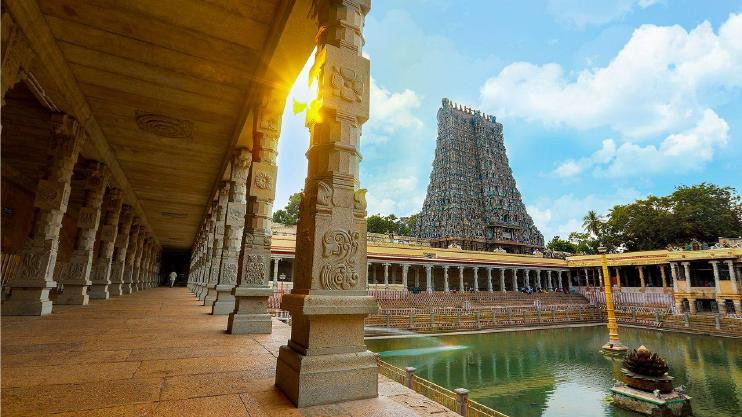

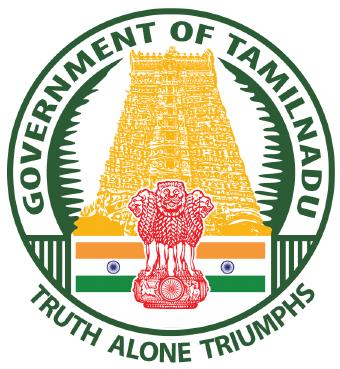

In [96]:
response = chain_with_sources.invoke(
    "Tell me about the state famous for temples"
)

# Tell me  about the state famous for temples?
# Tell me about India's Detroit
# Tell me about Durga Pooja
# Tell me about Metro trains
print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)